In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
# import uproot
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT
import coffea


In [2]:
dir_full = '/eos/user/b/bbapi/My_Analysis/NTuples_full/M20_RunIISummer20UL18NanoAODv9/nominal/'

In [3]:
Leptons_full = ak.from_parquet(dir_full+'leptons')

In [4]:
Leptons_full.pt

<Array [[4.97], [181, 18, ... [51.6, 3.44]] type='996614 * var * float32'>

In [6]:
Electrons_full = Leptons_full[abs(Leptons_full.pdgId)==11]
Electrons_full = Electrons_full[ak.num(Electrons_full.pt)>0]

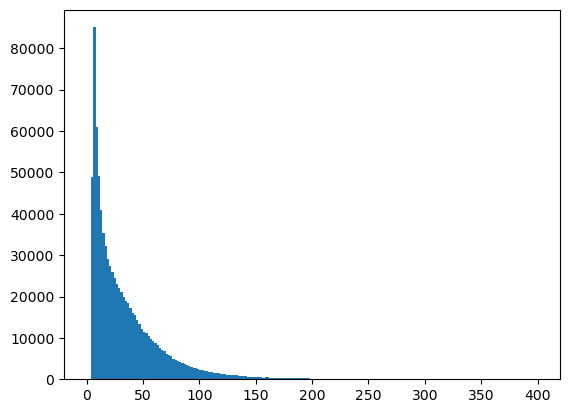

In [7]:
plt.hist(ak.flatten(Electrons_full.pt), bins = 200, range=(0, 400));

In [2]:
single = '/eos/user/b/bbapi/CMSSW_13_3_1_patch1/src/NanoAODProduction/NanoAODv13/test/M20-RunIISummer20UL18NanoAODv2/B7D21F37-159B-4F42-B1A8-97F4732749B9.root'

In [3]:
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# factory = NanoEventsFactory.from_root(
#     single,
#     treepath="Events",
#     schemaclass=NanoAODSchema,   # <--- use schemaclass, not schema
# )
# events = factory.events()
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema



factory = NanoEventsFactory.from_root(
    f"{single}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events = ak.materialize(events)



In [4]:
events.Muon.fields

['highPtId',
 'highPurity',
 'inTimeMuon',
 'isGlobal',
 'isPFcand',
 'isStandalone',
 'isTracker',
 'jetNDauCharged',
 'looseId',
 'mediumId',
 'mediumPromptId',
 'miniIsoId',
 'multiIsoId',
 'mvaMuID_WP',
 'nStations',
 'nTrackerLayers',
 'pfIsoId',
 'puppiIsoId',
 'softId',
 'softMvaId',
 'tightCharge',
 'tightId',
 'tkIsoId',
 'triggerIdLoose',
 'jetIdx',
 'svIdx',
 'fsrPhotonIdx',
 'charge',
 'pdgId',
 'dxy',
 'dxyErr',
 'dxybs',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaMuID',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'pfRelIso04_all',
 'phi',
 'pt',
 'ptErr',
 'segmentComp',
 'sip3d',
 'softMva',
 'tkRelIso',
 'tunepRelPt',
 'bsConstrainedChi2',
 'bsConstrainedPt',
 'bsConstrainedPtErr',
 'mvaLowPt',
 'mvaTTH',
 'genPartFlav',
 'genPartIdx',
 'fsrPhotonIdxG',
 'genPartIdxG',
 'jetIdxG']

In [60]:
events.Electron.fields

['seediEtaOriX',
 'convVeto',
 'cutBased',
 'cutBased_HEEP',
 'isEB',
 'isEcalDriven',
 'isPFcand',
 'istrackerDriven',
 'jetNDauCharged',
 'lostHits',
 'mvaIso_WP80',
 'mvaIso_WP90',
 'mvaIso_WPL',
 'mvaNoIso_WP80',
 'mvaNoIso_WP90',
 'mvaNoIso_WPL',
 'seedGain',
 'tightCharge',
 'jetIdx',
 'photonIdx',
 'svIdx',
 'fsrPhotonIdx',
 'charge',
 'closestKFNLayers',
 'clustersSize',
 'nBrem',
 'nSaturatedXtals',
 'nValidPixBarrelHits',
 'nValidPixEndcapHits',
 'numberOfClusters',
 'pdgId',
 'seediPhiOriY',
 'trkLayersWithMeas',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'DeltaEtaInSC',
 'DeltaEtaInSeed',
 'DeltaPhiInSC',
 'DeltaPhiInSeed',
 'GSFchi2',
 'PreshowerEnergy',
 'closestKFchi2',
 'convVtxFitProb',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03HcalTowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'e1x5',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right'

In [13]:
events.Electron[ak.num(events.Electron.pt)>0].pt

<Array [[30.8], ..., [58.1, 39.8, 14.9]] type='40153 * var * float32[parame...'>

In [54]:
def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)


def photon_preselections(
    photons: ak.Array,
    events: ak.Array,
    electron_veto=True,
    revert_electron_veto=False,
    year="2018",
    wp_medium=0.2783,
    IsFlag=False):
    """
    Apply full preselection on leptons, jets, and photons.
    Finally return only photons from events that pass all criteria.
    """

    print("Number of events before preselection:", len(events))

    # ------------------------
    # Lepton selection
    # ------------------------
    if year.startswith("2016"):
        ele_pt_cut, mu_pt_cut = 27, 26
    elif year == "2017":
        ele_pt_cut, mu_pt_cut = 33, 29
    elif year == "2018":
        # ele_pt_cut, mu_pt_cut = 33, 26
        ele_pt_cut, mu_pt_cut = 33, 26

    else:
        raise ValueError(f"Unknown year {year}")

    good_electrons = (
        (events.Electron.pt > ele_pt_cut)
        & (np.abs(events.Electron.eta) < 2.5)
        & (events.Electron.pfRelIso03_all < 0.15)
    )

    good_muons = (
        (events.Muon.pt > mu_pt_cut)
        & (np.abs(events.Muon.eta) < 2.4)
        & (events.Muon.pfRelIso03_all < 0.15)
    )

    one_ele = ak.num(events.Electron[good_electrons]) == 1
    one_mu = ak.num(events.Muon[good_muons]) == 1
    lepton_channel_mask = one_ele | one_mu
    # lepton_channel_mask = one_mu

    selected_electrons = events.Electron[good_electrons]
    print("selected_electrons", len(selected_electrons[ak.num(selected_electrons.pt)>0]))
    selected_muons = events.Muon[good_muons]
    print("selected_muons", len(selected_muons[ak.num(selected_muons.pt)>0]))
    selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)
    print("selected_leptons", len(selected_leptons[ak.num(selected_leptons.pt)>0]))
    print("selected Electrons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==11])>0]))
    print("selected Muons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==13])>0]))

    # ------------------------
    # Jet selection
    # ------------------------
    good_jets = (
        (events.Jet.pt > 20)
        & (np.abs(events.Jet.eta) < 2.4)
        # & (events.Jet.btagDeepFlavB > wp_medium)
    )
    selected_bjets = events.Jet[good_jets] 
    print("selected_b_jets: ", selected_bjets)
    at_least_two_bjets = ak.num(selected_bjets) >= 2

    # keep top 2 by DeepJet score
    # top2_bjets = selected_jets[ak.argsort(selected_jets.btagDeepFlavB, ascending=False)][:, :2]

    # ------------------------
    # Photon selection (from photon_preselection output)
    # ------------------------
    good_photons = (
        (photons.pt > 10)
        & (np.abs(photons.eta) < 2.5)
    )
    selected_photons = photons[good_photons]
    at_least_two_photons = ak.num(selected_photons) >= 2

    dr = delta_r_manual(selected_leptons, selected_photons)
    dr_mask = ak.all(ak.all(dr > 0.4, axis=-1), axis=-1)

    # ΔR between electrons and photons
    dr_electrons = delta_r_manual(selected_electrons, selected_photons)

    # ΔR between muons and photons
    dr_muons = delta_r_manual(selected_muons, selected_photons)


    # event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons & dr_mask
    # event_mask = at_least_two_bjets & at_least_two_photons & dr_mask
    event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons
    # event_mask = at_least_two_bjets & at_least_two_photons
    # event_mask = at_least_two_photons
    # event_mask = lepton_channel_mask & at_least_two_photons & dr_mask

    # ------------------------
    # Apply mask — keep length same, empties for failed events
    # ------------------------
    empty_photons = ak.Array([[]] * len(events))
    empty_bjets = ak.Array([[]] * len(events))
    empty_leptons = ak.Array([[]] * len(events))

    filtered_photons = ak.where(event_mask, selected_photons, empty_photons)
    filtered_jets = ak.where(event_mask, selected_bjets, empty_bjets)
    filtered_leptons = ak.where(event_mask, selected_leptons, empty_leptons)

    # ------------------------
    # Return photons (order preserved)
    # ------------------------
    return events.Muon, events.Electron, filtered_photons, filtered_jets, filtered_leptons, selected_leptons, selected_photons, dr, dr_mask, dr_electrons, dr_muons, event_mask, at_least_two_bjets

In [ ]:
# def delta_r_manual(obj1, obj2):
#     deta = obj1.eta[:, None] - obj2.eta
#     dphi = np.abs(obj1.phi[:, None] - obj2.phi)
#     dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
#     return np.sqrt(deta**2 + dphi**2)


# def photon_preselections(
#     photons: ak.Array,
#     events: ak.Array,
#     electron_veto=True,
#     revert_electron_veto=False,
#     year="2018",
#     wp_medium=0.2783,
#     IsFlag=False):
#     """
#     Apply full preselection on leptons, jets, and photons.
#     Finally return only photons from events that pass all criteria.
#     """

#     print("Number of events before preselection:", len(events))

#     # ------------------------
#     # Lepton selection
#     # ------------------------
#     if year.startswith("2016"):
#         ele_pt_cut, mu_pt_cut = 27, 26
#     elif year == "2017":
#         ele_pt_cut, mu_pt_cut = 33, 29
#     elif year == "2018":
#         # ele_pt_cut, mu_pt_cut = 33, 26
#         ele_pt_cut, mu_pt_cut = 33, 26

#     else:
#         raise ValueError(f"Unknown year {year}")

#     electrons = events.Electron

#     good_electrons = (
#         (electrons.pt > 33.0) &
#         (np.abs(electrons.eta) < 2.5) &  # keep within tracker acceptance
#         ~((np.abs(electrons.eta) > 1.44) & (np.abs(electrons.eta) < 1.57)) &  # remove transition
#         (electrons.mvaIso_WP80) &        # tight MVA ID
#         (electrons.pfRelIso03_all < 0.15)  # isolation cut
#     )

#     good_muons = (
#         (events.Muon.pt > mu_pt_cut)
#         & (np.abs(events.Muon.eta) < 2.4)
#         & (events.Muon.pfRelIso03_all < 0.15)
#     )

#     one_ele = ak.num(events.Electron[good_electrons]) == 1
#     one_mu = ak.num(events.Muon[good_muons]) == 1
#     lepton_channel_mask = one_ele | one_mu
#     # lepton_channel_mask = one_mu

#     selected_electrons = events.Electron[good_electrons]
#     print("selected_electrons", len(selected_electrons[ak.num(selected_electrons.pt)>0]))
#     selected_muons = events.Muon[good_muons]
#     print("selected_muons", len(selected_muons[ak.num(selected_muons.pt)>0]))
#     selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)
#     print("selected_leptons", len(selected_leptons[ak.num(selected_leptons.pt)>0]))
#     print("selected Electrons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==11])>0]))
#     print("selected Muons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==13])>0]))

#     # ------------------------
#     # Jet selection
#     # ------------------------
#     good_jets = (
#         (events.Jet.pt > 20)
#         & (np.abs(events.Jet.eta) < 2.4)
#         & (events.Jet.btagDeepFlavB > wp_medium)
#     )
#     selected_bjets = events.Jet[good_jets] 
#     print("selected_b_jets: ", selected_bjets)
#     at_least_two_bjets = ak.num(selected_bjets) >= 2

#     # keep top 2 by DeepJet score
#     # top2_bjets = selected_jets[ak.argsort(selected_jets.btagDeepFlavB, ascending=False)][:, :2]

#     # ------------------------
#     # Photon selection (from photon_preselection output)
#     # ------------------------

#     abs_eta = np.abs(photons.eta)

#     # Barrel–endcap transition exclusion (1.442 ≤ |η| ≤ 1.566)
#     valid_eta = (abs_eta <= 2.5) & ~((abs_eta >= 1.442) & (abs_eta <= 1.566))

#     # Barrel vs Endcap ID cuts
#     is_barrel = abs_eta < 1.442
#     is_endcap = (abs_eta > 1.566) & (abs_eta < 2.5)

#     # Apply region-specific MVA thresholds
#     barrel_cut = is_barrel & (photons.mvaID > -0.02)
#     endcap_cut = is_endcap & (photons.mvaID > -0.26)

#     # Combine everything
#     good_photons = (
#         (photons.pt > 10)
#         & valid_eta
#         & (barrel_cut | endcap_cut)
#         & (~photons.pixelSeed)
#     )
#     selected_photons = photons[good_photons]
#     at_least_two_photons = ak.num(selected_photons) >= 2

#     dr = delta_r_manual(selected_leptons, selected_photons)
#     dr_mask = ak.all(ak.all(dr > 0.4, axis=-1), axis=-1)

#     # ΔR between electrons and photons
#     dr_electrons = delta_r_manual(selected_electrons, selected_photons)

#     # ΔR between muons and photons
#     dr_muons = delta_r_manual(selected_muons, selected_photons)


#     event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons & dr_mask
#     # event_mask = at_least_two_bjets & at_least_two_photons & dr_mask
#     # event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons
#     # event_mask = at_least_two_bjets & at_least_two_photons
#     # event_mask = at_least_two_photons
#     # event_mask = lepton_channel_mask & at_least_two_photons & dr_mask

#     # ------------------------
#     # Apply mask — keep length same, empties for failed events
#     # ------------------------
#     empty_photons = ak.Array([[]] * len(events))
#     empty_bjets = ak.Array([[]] * len(events))
#     empty_leptons = ak.Array([[]] * len(events))

#     filtered_photons = ak.where(event_mask, selected_photons, empty_photons)
#     filtered_jets = ak.where(event_mask, selected_bjets, empty_bjets)
#     filtered_leptons = ak.where(event_mask, selected_leptons, empty_leptons)

#     # ------------------------
#     # Return photons (order preserved)
#     # ------------------------
#     return events.Muon, events.Electron, filtered_photons, filtered_jets, filtered_leptons, selected_leptons, selected_photons, dr, dr_mask, dr_electrons, dr_muons, event_mask, at_least_two_bjets

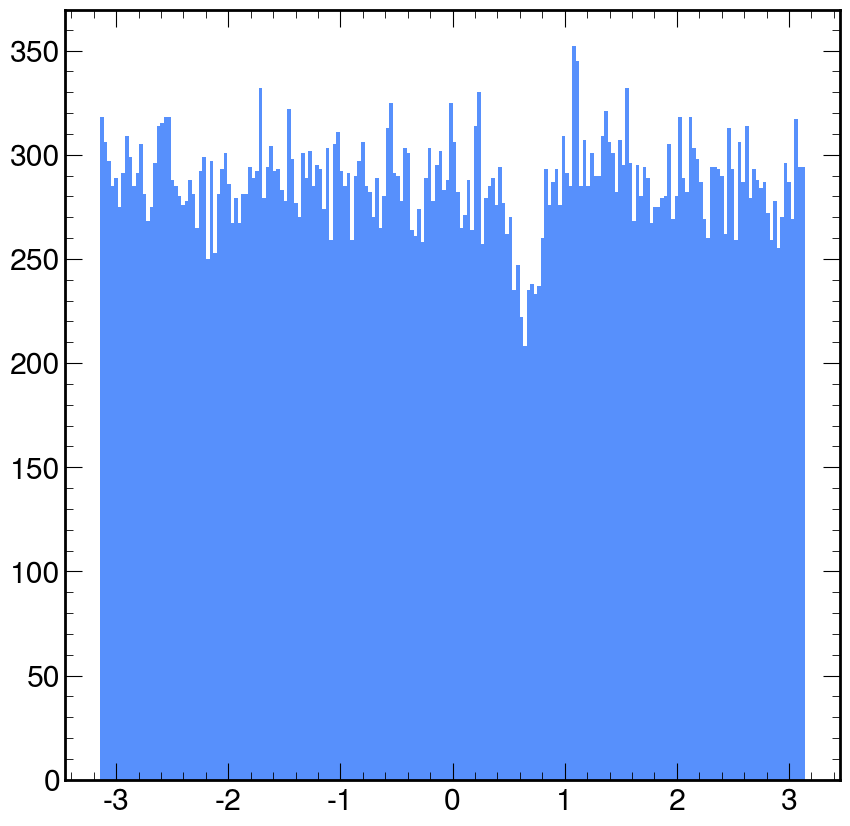

In [67]:
plt.hist(ak.flatten(events.Electron.phi), bins = 200);

In [69]:
events.Electron.phi[1]

<Array [-2.88] type='1 * float32[parameters={"__doc__": "phi"}]'>

In [73]:
events.Electron.eta[1]

<Array [1.25] type='1 * float32[parameters={"__doc__": "eta"}]'>

In [70]:
events.Photon.phi[1]

<Array [1.64, -2.89, 2.39, -1.37] type='4 * float32[parameters={"__doc__": "phi"}]'>

In [74]:
events.Photon.eta[1]

<Array [1.37, 1.25, 1.61, 1.09] type='4 * float32[parameters={"__doc__": "eta"}]'>

In [89]:
b=12
delta_r_manual(events.Electron[b], events.Photon[b])

obj1.eta[:, None]  [[2.31], [2.61]]
obj2.eta  [2.31, 2.61]
obj1.phi[:, None]  [[1.08], [-1.93]]
obj2.phi  [1.08, -1.93]
dR [[0.00503, 3.02], [3.03, 0.00628]]


<Array [[0.00503, 3.02], [3.03, 0.00628]] type='2 * 2 * float32'>

In [78]:
def delta_r_manual(obj1, obj2):
    print("obj1.eta[:, None] ", obj1.eta[:, None] )
    print("obj2.eta ", obj2.eta )
    deta = obj1.eta[:, None] - obj2.eta
    print("obj1.phi[:, None] ", obj1.phi[:, None] )
    print("obj2.phi ", obj2.phi )
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    print("dR", np.sqrt(deta**2 + dphi**2))
    return np.sqrt(deta**2 + dphi**2)

In [117]:
dr_ele_all = delta_r_manual(events.Electron, events.Photon)

In [118]:
dr_ele_all

<Array [[[]], ... [0.442, 3.14, 0.109]]] type='66000 * var * var * float32'>

In [ ]:
dr_ele_large[ak.num(dr_ele_large, axis =2)>0]


<Array [[], [[1.77], [1.07], [1.52]], []] type='3 * var * var * float32'>

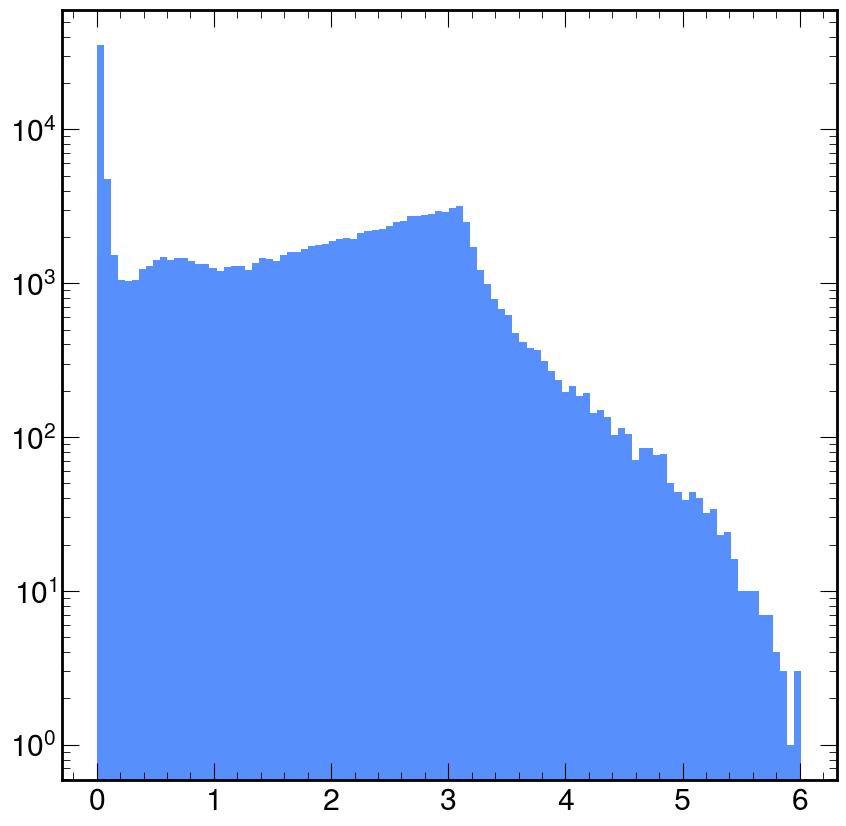

In [95]:
plt.hist(ak.flatten(ak.flatten(dr_ele_all)), bins = 100);
plt.yscale("log")

In [74]:
f_photons, f_jets, f_leps = photon_preselections(events.Photon, events)

Number of events before preselection: 66000
selected_b_jets:  [[Jet, Jet], [Jet, Jet, Jet], [Jet, ... Jet, Jet, Jet, Jet], [Jet, Jet, Jet, Jet]]


In [36]:
f_photons = f_photons[ak.num(f_photons.pt)>0]

In [16]:
f_photons.pt

<Array [[36.5, 11.8, 10.3], ... [33.5, 31]] type='506 * var * float32[parameters...'>

In [20]:
f_photons.pt

<Array [[35.2, 18.9], ... 63.9, 60.2, 12.1]] type='1499 * var * float32[paramete...'>

In [24]:
f_photons.pt

<Array [[22.1, 12.3], ... 63.9, 60.2, 12.1]] type='3631 * var * float32[paramete...'>

In [28]:
f_photons.pt

<Array [[50.7, 30.3, 12.5, ... 34.9, 15.7]] type='43278 * var * float32[paramete...'>

In [32]:
f_photons.pt

<Array [[56.5, 37.7], [19, ... [24.1, 23.6]] type='7398 * var * float32[paramete...'>

In [37]:
f_photons.pt

<Array [[56.5, 37.7], [19, ... [24.1, 23.6]] type='7360 * var * float32[paramete...'>

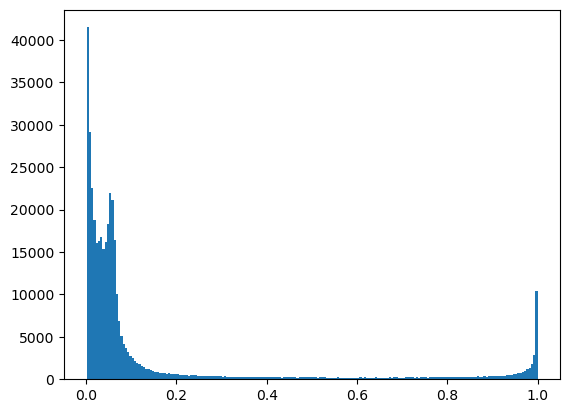

In [40]:
plt.hist(ak.flatten(events.Jet.btagDeepFlavB), bins = 200);

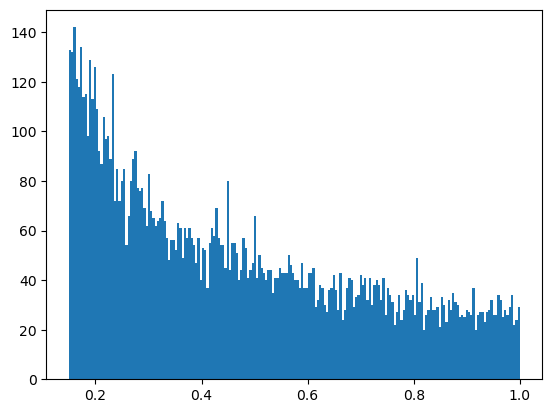

In [96]:
plt.hist(ak.flatten(events.Electron.pfRelIso03_all), range = (0.15, 1.0), bins = 200);

In [55]:
all_Mu, all_ele, f_photons, f_jets, f_leps, sel_leps, sel_pho, dr, mask, dr_ele, dr_mu, eve_mask, two_bj = photon_preselections(events.Photon, events)
f_leps = f_leps[ak.num(f_leps.pt)>0]
Electrons = f_leps[ak.num(f_leps[abs(f_leps.pdgId)==11])>0]
Muons = f_leps[ak.num(f_leps[abs(f_leps.pdgId)==13])>0]


Number of events before preselection: 66000
selected_electrons 17612
selected_muons 15642
selected_leptons 31512
selected Electrons 17612
selected Muons 15642
selected_b_jets:  [[Jet, ...], ...]


In [13]:
Electrons.pt

<Array [[56.8], [43.6], ..., [141], [64.2]] type='174 * var * float32[param...'>

In [14]:
f_leps.pt

<Array [[64.8], [56.8], ..., [89.9], [64.2]] type='404 * var * float32[para...'>

In [64]:
Electrons.pt

<Array [[40], [76.3], ... [93.8], [31.6]] type='35 * var * float32'>

In [90]:
Electrons.pt

<Array [[40], [76.3], ... [82.7], [93.8]] type='33 * var * float32'>

In [102]:
Electrons.pt

<Array [[40], [76.3], ... [82.7], [93.8]] type='33 * var * float32'>

In [20]:
Electrons.pt

<Array [[57.9], [92], ..., [36.1], [33.9]] type='13371 * var * float32[para...'>

In [9]:
electron_arr = np.array(ak.flatten(Electrons.pt))

In [10]:
%jsroot on

# Create histogram
h = ROOT.TH1F("hLepton", "Lepton pT", 200, 0, 400)

# Fill it
for pt in electron_arr:
    h.Fill(pt)

# Draw
c = ROOT.TCanvas("c","Lepton pt",800,600)
h.Draw()
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hLepton (Potential memory leak).


In [17]:
Muons.pt

<Array [[73.7], [35.6], ..., [40.5], [36]] type='8649 * var * float32[param...'>

In [24]:
ak.all(ak.num(Electrons.pt)>1)

True

In [8]:
len(sel_pho)

66000

In [9]:
len(sel_leps)

66000

In [10]:
len(dr)

66000

In [11]:
len(mask)

66000

In [44]:
ak.where(eve_mask == True)

(<Array [384, 497, 866, 928, ..., 65571, 65752, 65905, 65936] type='404 * int64'>,)

In [49]:
a = 928
print("al_Mu", all_Mu.pt[a])
print("al_ele", all_ele.pt[a])
print("sel_pho", sel_pho.pt[a])
print("sel_leps", sel_leps.pt[a])
print("dr", dr[a])
print("mask", mask[a])
print("at least two bjets", two_bj[a])
print("event mask", eve_mask[a])


al_Mu [82.2, 6.93]
al_ele [6.45]
sel_pho [46.1, 43.9]
sel_leps [82.2]
dr [[3.08], [2.7]]
mask True
at least two bjets True
event mask True


In [34]:
dr

<Array [[[]], [[], ... 0.0944], [0.442, 3.14]]] type='66000 * var * var * float32'>

In [79]:
sel_leps[ak.num(sel_leps.pt)>1].pdgId[:10]

<Array [[11, -11, -11], ... [-11, -13]] type='10 * var * int32[parameters={"__do...'>

In [ ]:
sel_eles = sel_leps[abs(sel_leps.pdgId) == 11]

In [47]:
sel_eles[ak.num(sel_eles)>0].pdgId[35:40]

<Array [[-11], [11], [-11], [11], [-11]] type='5 * var * int32[parameters={"__do...'>

In [41]:
dr_ele

<Array [[[]], [[], ... 0.0944], [0.442, 3.14]]] type='66000 * var * var * float32'>

Text(0.5, 1.0, 'dr between electron and photons')

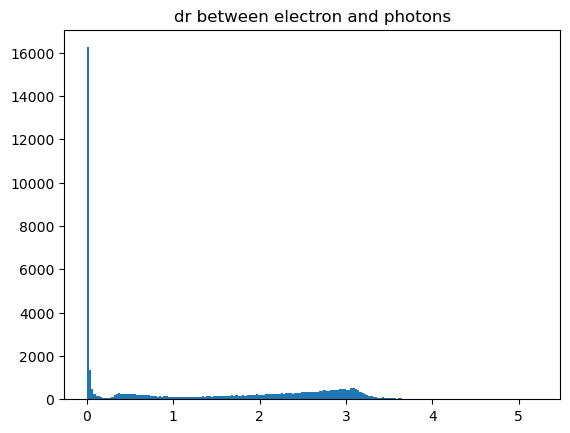

In [46]:
plt.hist(ak.flatten(ak.flatten(dr_ele)), bins=200);
plt.title("dr between electron and photons")

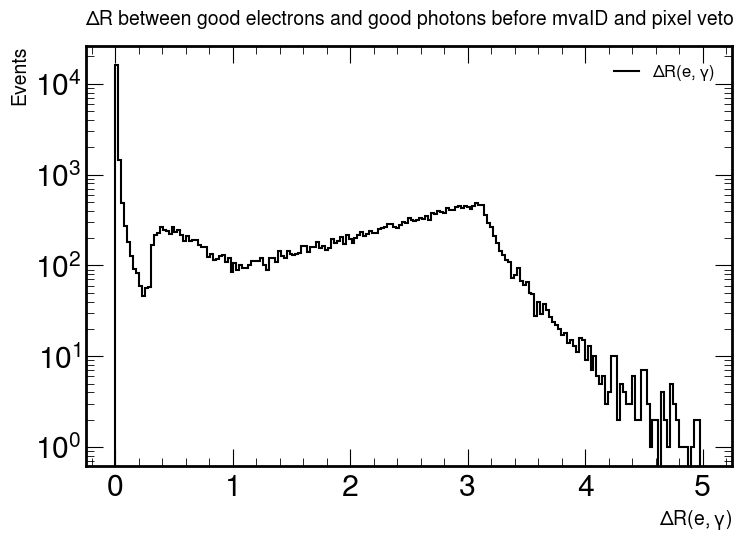

In [57]:
import mplhep as hep

plt.style.use(hep.style.CMS)

# Flatten ΔR array
dr_flat = ak.to_numpy(ak.flatten(ak.flatten(dr_ele)))

# Compute histogram
counts, bins = np.histogram(dr_flat, bins=np.linspace(0, 5, 200))

# Plot using mplhep
fig, ax = plt.subplots(figsize=(8, 6))
hep.histplot(counts, bins=bins, histtype="step", color="black", label=r"$\Delta R(e, \gamma)$")

# Axis settings
ax.set_yscale("log")
ax.set_xlabel(r"$\Delta R(e, \gamma)$", fontsize=14)
ax.set_ylabel("Events", fontsize=14)

# Add legend
ax.legend(fontsize=12, loc="upper right")

# Custom title (no CMS/lumi)
ax.set_title("ΔR between good electrons and good photons before mvaID and pixel veto", fontsize=14, pad=15)

plt.tight_layout()
plt.show()

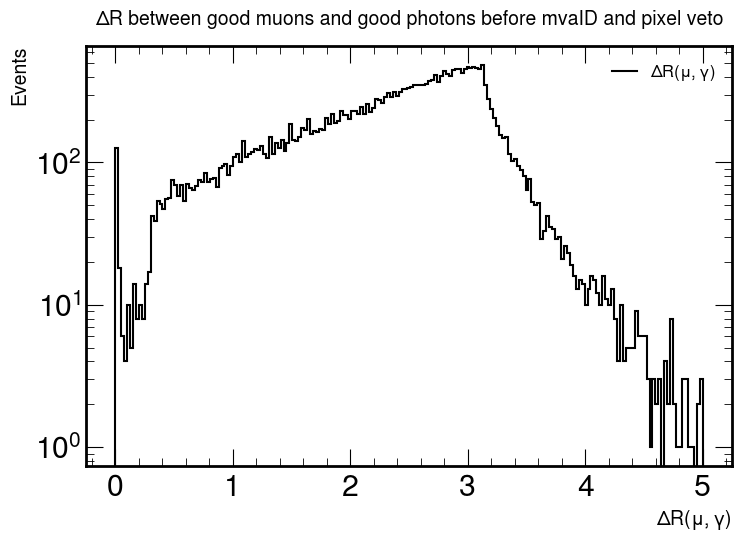

In [59]:
plt.style.use(hep.style.CMS)

# Flatten ΔR array
dr_flat = ak.to_numpy(ak.flatten(ak.flatten(dr_mu)))

# Compute histogram
counts, bins = np.histogram(dr_flat, bins=np.linspace(0, 5, 200))

# Plot using mplhep
fig, ax = plt.subplots(figsize=(8, 6))
hep.histplot(counts, bins=bins, histtype="step", color="black", label=r"$\Delta R(\mu, \gamma)$")

# Axis settings
ax.set_yscale("log")
ax.set_xlabel(r"$\Delta R(\mu, \gamma)$", fontsize=14)
ax.set_ylabel("Events", fontsize=14)

# Add legend
ax.legend(fontsize=12, loc="upper right")

# Custom title (no CMS/lumi)
ax.set_title("ΔR between good muons and good photons before mvaID and pixel veto", fontsize=14, pad=15)

plt.tight_layout()
plt.show()

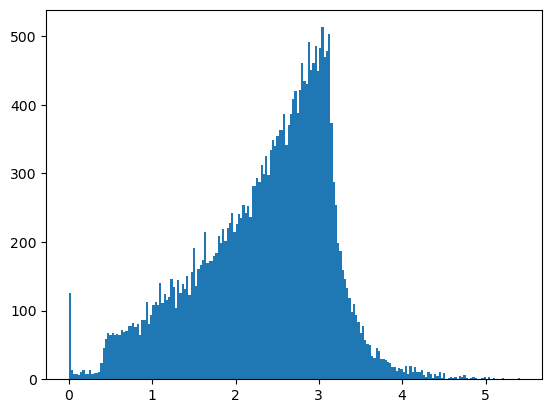

In [44]:
plt.hist(ak.flatten(ak.flatten(dr_mu)), bins=200);